# Detection and Tracking Tutorial

Download the tutorial code

[detection_and_tracking.ipynb](https://docs.prophesee.ai/stable/_downloads/affaf0115f82b631ca2719e536cc9da9/detection_and_tracking.ipynb)

In this tutorial, we learn how to use a pre-trained network for the detection and tracking of cars and pedestrians. At the end of this tutorial, we will have a full pipeline that takes events in input and outputs the position and id of cars and pedestrians in the field of view. Note that we also provide a [detection and tracking sample](https://docs.prophesee.ai/stable/metavision_sdk/modules/ml/samples/detection_and_tracking_inference.html#chapter-sdk-ml-detection-and-tracking-inference).

The dataflow of the events is the following:

  * Read the events from an event-based camera or a RAW/DAT file
  * Preprocess the events 
  * Two parallel branches: one for ML detection and another for the data association:

    * Runtime inference to extract the Detection from preprocessed events
    * Noise Filtering (STC, Trail...) + Data association
    
  * Merge all the results and display them

This is the pipeline:

![DT_Pipeline](https://docs.prophesee.ai/stable/_images/DT_Pipeline.png "DT_Pipeline")

Let's start by loading the required libraries and some data:

In [1]:
import os
import cv2
import numpy as np

import torch

# Import of Metavision Machine Learning binding
import metavision_sdk_ml
import metavision_sdk_cv
from metavision_sdk_core import EventBbox

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [11, 7]

In [2]:
from metavision_core.utils import get_sample

file_dir = "../sample_recordings"
SEQUENCE_FILENAME_RAW = "driving_sample.raw"
# if the file doesn't exist, it will be downloaded from Prophesee's public sample server 
get_sample(SEQUENCE_FILENAME_RAW, folder=file_dir)
SEQUENCE_FILENAME_RAW = os.path.join(file_dir, SEQUENCE_FILENAME_RAW)
assert os.path.isfile(SEQUENCE_FILENAME_RAW)

## Pipeline Components
### Event Producer

The event producer generates a stream of event to feed the pipeline.

We use an object **metavision_core.event_io.EventsIterator** to produce the stream of events. We choose to process the data 10ms at a time as this gives a good tradeoff between low latency and performance.

Dimensions: 1280 720
[( 874, 200, 0, 4096) ( 806, 200, 1, 4096) ( 882, 201, 0, 4096) ...
 (1273,  82, 0, 9999) ( 375,  82, 1, 9999) (1170,  82, 1, 9999)]


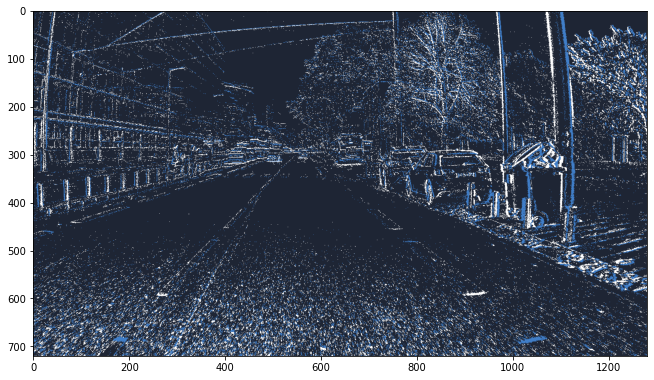

In [3]:
from metavision_core.event_io import EventsIterator
from metavision_sdk_core import BaseFrameGenerationAlgorithm

DELTA_T = 10000  # 10 ms

def init_event_producer():
    return EventsIterator(SEQUENCE_FILENAME_RAW, start_ts=0, delta_t=DELTA_T, relative_timestamps=False)

#initialize an iterator to get the sensor size
mv_it = init_event_producer()
ev_height, ev_width = mv_it.get_size()

print("Dimensions:", ev_width, ev_height)

for ev in mv_it:
    # (x, y, p, t)
    print(ev)
    break
image = np.zeros((ev_height, ev_width, 3), dtype=np.uint8)
BaseFrameGenerationAlgorithm.generate_frame(ev, image)
plt.imshow(image[:,:,::-1])

### Detection



The next block to build is the detection block. The detection is done using a neural network inference based on [PyTorch](https://pytorch.org/). The provided model is a Torch model saved using [jit.save()](https://pytorch.org/docs/stable/generated/torch.jit.save.html).

You can use this model directly with Torch, but our **`metavision_ml.detection_tracking.object_detector.ObjectDetector`** class provides additional features, such as result extraction and parsing, thresholding, non-minima suppression, and more.
First, we need a pre-trained TorchScript model with a JSON file of hyperparameters. Check our [pre-trained models page](https://docs.prophesee.ai/stable/metavision_sdk/modules/ml/pre-trained_models.html#chapter-ml-pretrained-models) to find out how to download one of the object detection TorchScript models. Move the models folders (``red_event_cube_05_2020`` and ``red_histogram_05_2020``) in your local folder or update the path in the following code.

Now, we need to load the model and define some parameters.


In [4]:
USE_EVENT_CUBE_MODEL = False

if USE_EVENT_CUBE_MODEL:
    NN_MODEL_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), "../pre_trained_models/red_event_cube_05_2020"))
else:
    NN_MODEL_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), "../pre_trained_models/red_histogram_05_2020"))

print("NN_MODEL_DIRECTORY: ", NN_MODEL_DIRECTORY)

# check whether we can use the GPU or we should fall back on the CPU
DEVICE = "cpu"  # "cpu", "cuda" (or "cuda:0", "cuda:1", etc.)
if torch.cuda.is_available():
    DEVICE = "cuda"

NN_DOWNSCALE_FACTOR = 2 # divide events input height and width by this factor before applying NN, this gives us a good trade-off between accuracy and performance
DETECTOR_SCORE_THRESHOLD = 0.4 # ignore all detections below this threshold
NMS_IOU_THRESHOLD = 0.4 # apply Non-Maximum Suppression when the intersection over union (IOU) is above this threshold

NN_MODEL_DIRECTORY:  /home/tkyen/opencv_practice/metavision/metavision_sdk/pre_trained_models/red_histogram_05_2020


Now, let's load the model and create an ``ObjectDetector``

In [5]:
from metavision_ml.detection_tracking import ObjectDetector

network_input_width  = ev_width  // NN_DOWNSCALE_FACTOR
network_input_height = ev_height // NN_DOWNSCALE_FACTOR

object_detector = ObjectDetector(NN_MODEL_DIRECTORY,
                                 events_input_width=ev_width,
                                 events_input_height=ev_height,
                                 runtime=DEVICE,
                                 network_input_width=network_input_width,
                                 network_input_height=network_input_height)
object_detector.set_detection_threshold(DETECTOR_SCORE_THRESHOLD)
object_detector.set_iou_threshold(NMS_IOU_THRESHOLD)

Now that we have a detector object, we need to setup a function to use it.
Note how, in this case, the object detector has its own data preprocessing component, which we can get with the ``get_cd_processor()`` function. For this reason, we do not need to use other preprocessing tools. It is possible to load the model directly using the Torch functions. In that case, it would be required to prepare the data in input using our preprocessing tools, as presented in the tutorial [Event Preprocessing](https://docs.prophesee.ai/stable/metavision_sdk/modules/ml/data_processing/event_preprocessing.html). This approach using directly Torch functions is presented in the tutorial [Reusing a Torchjit Model](https://docs.prophesee.ai/stable/metavision_sdk/modules/ml/inference/using_torchjit_model.html).

Let's get the preprocessing component of our object detector.

In [6]:
cdproc = object_detector.get_cd_processor()
frame_buffer = cdproc.init_output_tensor()
print("frame_buffer.shape: ", frame_buffer.shape)
if USE_EVENT_CUBE_MODEL:
    assert frame_buffer.shape == (10, network_input_height, network_input_width)
else:
    assert frame_buffer.shape == (2, network_input_height, network_input_width)
assert (frame_buffer == 0).all()

frame_buffer.shape:  (2, 360, 640)


Finally, we can define the detection function. At each iteration we process the events to prepare them for the network.This is done with the ``cdproc.process_events()`` function which builds an input tensor incrementally before it is fed to the neural network.``current_frame_start_ts`` is used to keep track of the starting timestamp of the current frame_buffer.

The call to the ``object_detector.process()`` is not done at each iteration of 10ms.It is done at a frequency that is defined for each model at training time. This can be obtained with the function ``get_accumulation_time()``.

In [7]:
NN_accumulation_time = object_detector.get_accumulation_time()
def generate_detection(ts, ev):
    current_frame_start_ts = ((ts-1) // NN_accumulation_time) * NN_accumulation_time
    cdproc.process_events(current_frame_start_ts, ev, frame_buffer)

    detections = np.empty(0, dtype=EventBbox)
    
    if ts % NN_accumulation_time == 0:  # call the network only when defined
        # call neural network to detect objects 
        detections = object_detector.process(ts, frame_buffer)
        # reset neural network input frame
        frame_buffer.fill(0)
    return detections
print("NN_accumulation_time: ", NN_accumulation_time)

NN_accumulation_time:  50000


At this point, we have the building blocks to read the events, preprocess them, and run the detector to obtain the position of cars and pedestrians.
The information obtained from the network only refers to the particular batch of events we passed to the detector.If we want to associate an ID to each object we detected and track them over time, we need to use the ``DataAssociation`` class.We will see how to do it in the next sections.

### Noise Filtering

The data association component works better if we first remove all "noisy" events.We can do this in many different ways, but in this tutorial, we will use the ``TrailFilterAlgorithm``.This filter works in the following way: for each pixel, we only keep the first event received, all subsequent events received between the start of the event batch and a temporal threshold defined by the user are discarded.

In [8]:
TRAIL_THRESHOLD=10000
trail = metavision_sdk_cv.TrailFilterAlgorithm(width=ev_width, height=ev_height, threshold=TRAIL_THRESHOLD)

We can now create the building block for filtering the events.

In [9]:
# Filter done after the detection
ev_filtered_buffer = trail.get_empty_output_buffer()
def noise_filter(ev):
    # apply trail filter
    trail.process_events(ev, ev_filtered_buffer)
    return ev_filtered_buffer.numpy()

### Data Association
Now that we have the correct input for the data association block, we can initialize it like this:

In [10]:
def init_data_association():
    return metavision_sdk_ml.DataAssociation(width=ev_width, height=ev_height, max_iou_inter_track=0.3)

At this point, we have all the building blocks for detection and tracking. What we are missing is a way to visualize the results.

### Video Output Generation

First, let's enable the visualization (you can set an environment variable if you want to run this procedurally without display) and the output path.

In [11]:
DO_DISPLAY = False and os.environ.get("DOC_DISPLAY", 'ON') != "OFF" # display the result in a window
OUTPUT_VIDEO = os.path.join(file_dir, "detection_and_tracking.mp4") # output video (disabled if the string is empty. Set a file name to save the video)
print("DO_DISPLAY: ", DO_DISPLAY)
print("OUTPUT_VIDEO: ", OUTPUT_VIDEO)

DO_DISPLAY:  False
OUTPUT_VIDEO:  ../sample_recordings/detection_and_tracking.mp4


Video generation is done using [scikit-video](http://www.scikit-video.org/stable/), which provides a wrapper around the FFmpeg library.

In [12]:
import numpy as np
from skvideo.io import FFmpegWriter

Now, we can create the initialization function for the visualization building block:

In [13]:
def init_output():
    if OUTPUT_VIDEO:
        assert OUTPUT_VIDEO.lower().endswith(".mp4"), "Video should be mp4"

    if DO_DISPLAY:
        cv2.namedWindow("Detection and Tracking", cv2.WINDOW_NORMAL)
    
    return FFmpegWriter(OUTPUT_VIDEO) if OUTPUT_VIDEO else None

if OUTPUT_VIDEO or DO_DISPLAY:
    frame = np.zeros((ev_height, ev_width * 2, 3), dtype=np.uint8)

Note how we initialized the first frame as an empty Numpy array of the same size as the expected output.

Finally, we can create the visualization building block.
We use an internal function called `draw_detections_and_tracklets` which takes in input the detections and the tracklets (which are the output of the data association block) and creates a clean visualization.

As you can see below, we first create the output with the `draw_detections_and_tracklets` function, and then we optionally display it or store it in a video (or both).

In [14]:
from metavision_ml.detection_tracking import draw_detections_and_tracklets
from metavision_sdk_core import BaseFrameGenerationAlgorithm

def generate_display(ts, ev, detections, tracklets, process_video):
    if OUTPUT_VIDEO or DO_DISPLAY:
        # build image frame
        BaseFrameGenerationAlgorithm.generate_frame(ev, frame[:, :ev_width])
        frame[:, ev_width:] = frame[:, :ev_width]
        draw_detections_and_tracklets(ts=ts, frame=frame, width=ev_width, height=ev_height,
                                         detections=detections, tracklets=tracklets)

    if DO_DISPLAY:
        # display image on screen
        cv2.imshow('Detection and Tracking', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            return False

    if OUTPUT_VIDEO:
        # write video
        process_video.writeFrame(frame[...,::-1].astype(np.uint8))
        
    return True
        
def end_display(process_video):
    # close video and window
    if OUTPUT_VIDEO:
        process_video.close()

    if DO_DISPLAY:
        cv2.destroyAllWindows()

## Creating the Final Pipeline

Now that we have all the building blocks, we can instantiate the pipeline and execute it:

In [15]:
mv_it = init_event_producer() # initialize the iterator to read the events
object_detector.reset() # reset the object detector internal memory before processing a sequence
data_assoc = init_data_association() #  initialize the data association block
data_assoc_buffer = data_assoc.get_empty_output_buffer()
process_video = init_output() # initialize the video generation

END_TS = 10 * 1e6 # process sequence until this timestamp (None to disable)

for ev in mv_it:
    ts = mv_it.get_current_time()

    if END_TS and ts > END_TS:
        break
    
    # run the detectors and get the output
    detections = generate_detection(ts, ev)

    # remove noisy events for processing with the data association block    
    noise_filtered_ev = noise_filter(ev)

    # compute tracklets
    data_assoc.process_events(ts, noise_filtered_ev, detections, data_assoc_buffer)
    tracklets = data_assoc_buffer.numpy()
    
    if not generate_display(ts, ev, detections, tracklets, process_video):
        # if the generation is stopped using `q`, break the loop
        break

# finalize the recording
end_display(process_video)

/usr/lib/python3/dist-packages/metavision_ml/detection_tracking/display_frame.py:72: RuntimeWarning: invalid value encountered in add
  botright_x = np.clip(box_events["x"] + box_events["w"], 0, width - 1).astype('int')
/usr/lib/python3/dist-packages/metavision_ml/detection_tracking/display_frame.py:73: RuntimeWarning: invalid value encountered in add
  botright_y = np.clip(box_events["y"] + box_events["h"], 0, height - 1).astype('int')


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt2'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


## Reloading Detections from a Text File

In this section, we demonstrate how the same pipeline can be used by gathering detected boxes from an external source. Here, we use the results from a previous run of our pipeline, where we stored the output in a CSV file, but any external detector could be used.

The same process could be used with any external object detector or ground truth, as long as the prediction bounding boxes are converted into a numpy array of `metavision_sdk_core.EventBbox.dtype`.

First, let's load the detections from a CSV file using the `detections_csv_loader()` function:

In [ ]:
import os
from urllib.request import urlretrieve
from metavision_ml.detection_tracking import detections_csv_loader

offline_detections = "driving_sample_detections.txt"

# if the file doesn't exist, it will be downloaded from Prophesee's public sample server 
if not os.path.exists(offline_detections):
    urlretrieve("https://dataset.prophesee.ai/index.php/s/cupakTZAbfnXrJe/download", filename=offline_detections)
        
NN_ACCUMULATION_TIME = 50000

dic_ts_eventbbox = detections_csv_loader(offline_detections)


Now we can create a function that loads the detection iteratively at the correct timestamp:

In [ ]:
def load_detection(ts, ev):
    detections = np.empty(0, dtype=EventBbox)
    if ts % NN_accumulation_time == 0:
        if ts in dic_ts_eventbbox:
            detections = dic_ts_eventbbox[ts]
    return detections

Finally, here is the new pipeline. This pipeline is the same as the one presented in the previous section, but with the detector replaced with our `load_detection` function.

In [ ]:
mv_it = init_event_producer() # initialize the iterator to read the events
data_assoc = init_data_association() #  initialize the data association block
data_assoc_buffer = data_assoc.get_empty_output_buffer()
process_video = init_output() # initialize the video generation

END_TS = 2 * 1e6 # process sequence until this timestamp (None to disable)

for ev in mv_it:
    ts = mv_it.get_current_time()
    if END_TS and ts > END_TS:
        break
   
    # load the precomputed detections
    detections = load_detection(ts, ev)

    # remove noisy events for processing with the data association block    
    noise_filtered_ev = noise_filter(ev)

    # compute tracklets
    data_assoc.process_events(ts, noise_filtered_ev, detections, data_assoc_buffer)
    tracklets = data_assoc_buffer.numpy()
    
    if not generate_display(ts, ev, detections, tracklets, process_video):
        # if the generation is stopped using `q`, break the loop
        break

end_display(process_video)